# Week 3: Calibration Analysis

Are our uncertainty estimates trustworthy? When the system says "90% confident," is it right 90% of the time?

This notebook covers:
1. Calibration metrics (ECE, MCE, Brier score)
2. Reliability diagrams — visual calibration check
3. Temperature scaling — fixing an overconfident model
4. Retrieval vs generation calibration comparison

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

from src.calibration import (
    expected_calibration_error,
    maximum_calibration_error,
    brier_score,
    reliability_diagram,
    TemperatureScaling,
    PlattScaling,
    RAGCalibrator,
)

np.random.seed(42)
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 11

## 1. Synthetic Calibration Examples

Let's create three models with different calibration properties.

In [2]:
n = 2000

# Well-calibrated: confidence ~ accuracy
conf_good = np.random.uniform(0, 1, n)
pred_good = (np.random.uniform(0, 1, n) < conf_good).astype(float)

# Overconfident: high confidence, mediocre accuracy
conf_over = np.clip(np.random.beta(5, 1, n), 0.5, 1.0)  # skewed high
pred_over = (np.random.uniform(0, 1, n) < 0.65).astype(float)  # 65% accuracy

# Underconfident: low confidence, decent accuracy
conf_under = np.clip(np.random.beta(1, 3, n), 0.0, 0.7)  # skewed low
pred_under = (np.random.uniform(0, 1, n) < 0.6).astype(float)

print('ECE (well-calibrated): {:.4f}'.format(expected_calibration_error(pred_good, conf_good)))
print('ECE (overconfident):   {:.4f}'.format(expected_calibration_error(pred_over, conf_over)))
print('ECE (underconfident):  {:.4f}'.format(expected_calibration_error(pred_under, conf_under)))

ECE (well-calibrated): 0.0165
ECE (overconfident):   0.2240
ECE (underconfident):  0.3479


## 2. Reliability Diagrams

The diagonal = perfect calibration. Above the diagonal = underconfident. Below = overconfident.

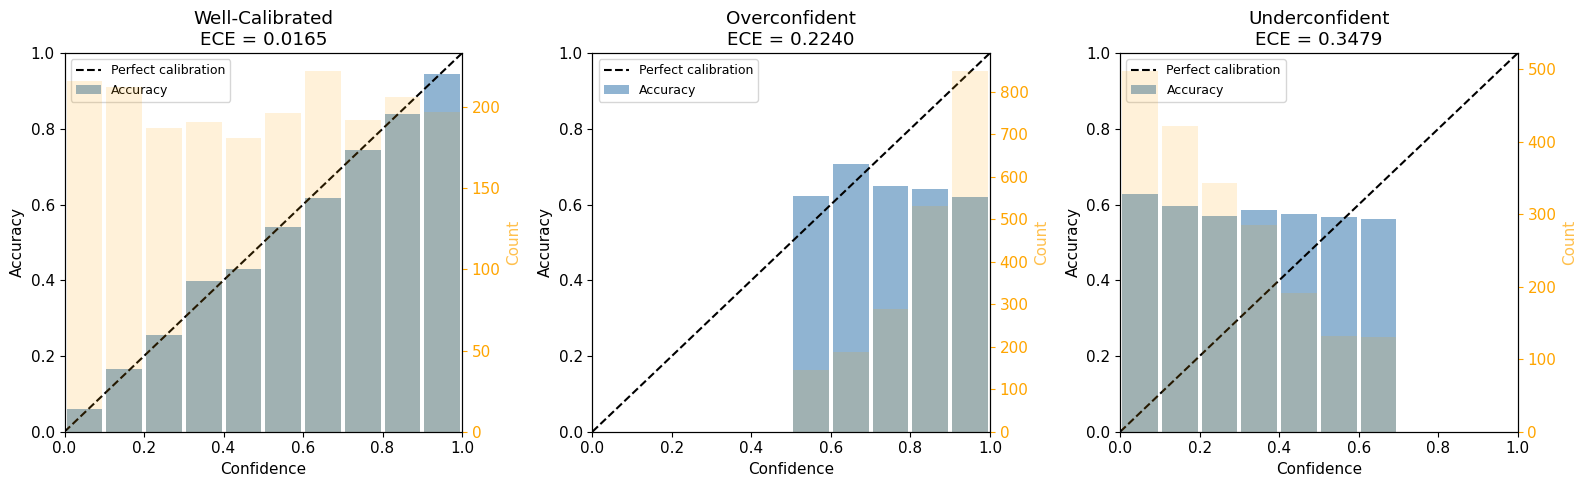

In [3]:
def plot_reliability(preds, confs, title, ax, n_bins=10):
    diag = reliability_diagram(preds, confs, n_bins=n_bins)
    mids = diag['bin_midpoints']
    accs = diag['bin_accuracies']
    counts = diag['bin_counts']
    ece = expected_calibration_error(preds, confs, n_bins)

    # bar chart of accuracy per bin
    width = 1.0 / n_bins
    ax.bar(mids, accs, width=width * 0.9, alpha=0.6, color='steelblue', label='Accuracy')
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Perfect calibration')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{title}\nECE = {ece:.4f}')
    ax.legend(loc='upper left', fontsize=9)

    # secondary axis for bin counts
    ax2 = ax.twinx()
    ax2.bar(mids, counts, width=width * 0.9, alpha=0.15, color='orange', label='Count')
    ax2.set_ylabel('Count', color='orange', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor='orange', colors='orange')

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
plot_reliability(pred_good, conf_good, 'Well-Calibrated', axes[0])
plot_reliability(pred_over, conf_over, 'Overconfident', axes[1])
plot_reliability(pred_under, conf_under, 'Underconfident', axes[2])
plt.tight_layout()
plt.show()

## 3. Temperature Scaling — Fixing Overconfidence

We create an overconfident multi-class classifier and show how temperature scaling brings it into line.

In [4]:
n_val, n_classes = 1000, 5
true_labels = np.random.randint(0, n_classes, n_val)

# overconfident logits: correct class gets a big spike
logits = np.random.randn(n_val, n_classes) * 0.3
for i in range(n_val):
    logits[i, true_labels[i]] += 8.0

# but flip 30% of labels -> model thinks it's right but isn't
labels = true_labels.copy()
flip_idx = np.random.choice(n_val, size=int(n_val * 0.3), replace=False)
for i in flip_idx:
    labels[i] = (labels[i] + 1) % n_classes

# before calibration
probs_before = softmax(logits, axis=1)
conf_before = probs_before.max(axis=1)
correct_before = (probs_before.argmax(axis=1) == labels).astype(float)

print(f'Before temperature scaling:')
print(f'  Mean confidence: {conf_before.mean():.4f}')
print(f'  Accuracy:        {correct_before.mean():.4f}')
print(f'  ECE:             {expected_calibration_error(correct_before, conf_before):.4f}')

Before temperature scaling:
  Mean confidence: 0.9985
  Accuracy:        0.7000
  ECE:             0.2985


In [5]:
ts = TemperatureScaling()
ts.fit(logits, labels)
print(f'Optimal temperature: {ts.temperature:.4f}')
print(f'(T > 1 means the model was overconfident, as expected)\n')

probs_after = ts.transform(logits)
conf_after = probs_after.max(axis=1)
correct_after = (probs_after.argmax(axis=1) == labels).astype(float)

print(f'After temperature scaling:')
print(f'  Mean confidence: {conf_after.mean():.4f}')
print(f'  Accuracy:        {correct_after.mean():.4f}')
print(f'  ECE:             {expected_calibration_error(correct_after, conf_after):.4f}')

Optimal temperature: 3.5909
(T > 1 means the model was overconfident, as expected)

After temperature scaling:
  Mean confidence: 0.6980
  Accuracy:        0.7000
  ECE:             0.0182


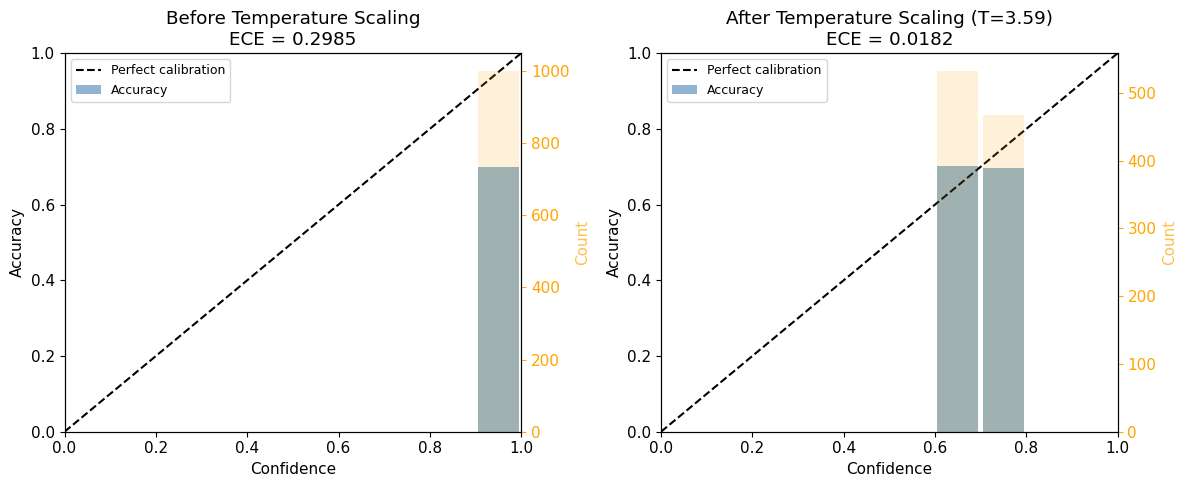

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_reliability(correct_before, conf_before, 'Before Temperature Scaling', axes[0])
plot_reliability(correct_after, conf_after, f'After Temperature Scaling (T={ts.temperature:.2f})', axes[1])
plt.tight_layout()
plt.show()

### ECE Breakdown by Bin

Visualize where the calibration gap lives — which confidence ranges are most miscalibrated.

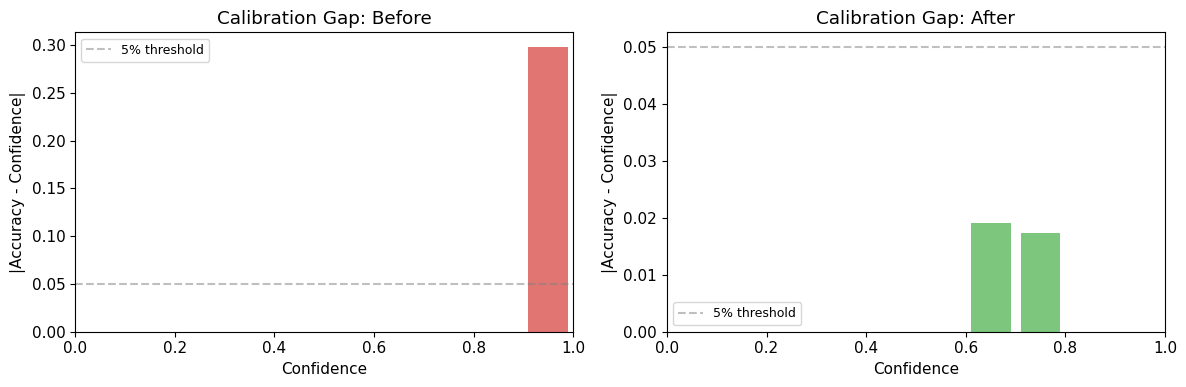

In [7]:
def plot_ece_bars(preds, confs, title, ax, n_bins=10):
    diag = reliability_diagram(preds, confs, n_bins=n_bins)
    mids = diag['bin_midpoints']
    accs = np.array(diag['bin_accuracies'])
    avg_confs = np.array(diag['bin_confidences'])
    counts = np.array(diag['bin_counts'])

    # gap = |acc - conf| weighted by count
    gaps = []
    for a, c in zip(accs, avg_confs):
        if np.isnan(a):
            gaps.append(0)
        else:
            gaps.append(abs(a - c))

    colors = ['#d9534f' if g > 0.1 else '#5cb85c' for g in gaps]
    ax.bar(mids, gaps, width=0.08, color=colors, alpha=0.8)
    ax.axhline(y=0.05, color='gray', linestyle='--', alpha=0.5, label='5% threshold')
    ax.set_xlabel('Confidence')
    ax.set_ylabel('|Accuracy - Confidence|')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.legend(fontsize=9)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_ece_bars(correct_before, conf_before, 'Calibration Gap: Before', axes[0])
plot_ece_bars(correct_after, conf_after, 'Calibration Gap: After', axes[1])
plt.tight_layout()
plt.show()

## 4. Retrieval Calibration with Platt Scaling

For binary retrieval relevance, we use Platt scaling instead of temperature scaling.

In [8]:
# simulate retrieval confidence scores (overconfident)
n_ret = 500
ret_relevant = np.random.randint(0, 2, n_ret).astype(float)  # ground truth
# model gives high scores to everything
ret_confs = np.where(
    ret_relevant == 1,
    np.random.beta(6, 2, n_ret),   # relevant: high-ish scores
    np.random.beta(4, 2, n_ret),   # irrelevant: also high (overconfident!)
)

ece_ret_before = expected_calibration_error(ret_relevant, ret_confs)
bs_ret_before = brier_score(ret_confs, ret_relevant)
print(f'Retrieval before Platt scaling:')
print(f'  ECE:   {ece_ret_before:.4f}')
print(f'  Brier: {bs_ret_before:.4f}\n')

ps = PlattScaling()
ps.fit(ret_confs, ret_relevant)
ret_calibrated = ps.transform(ret_confs)

ece_ret_after = expected_calibration_error(ret_relevant, ret_calibrated)
bs_ret_after = brier_score(ret_calibrated, ret_relevant)
print(f'Retrieval after Platt scaling ({ps}):')
print(f'  ECE:   {ece_ret_after:.4f}')
print(f'  Brier: {bs_ret_after:.4f}')

Retrieval before Platt scaling:
  ECE:   0.1859
  Brier: 0.2717

Retrieval after Platt scaling (PlattScaling(a=2.9737, b=-2.0151)):
  ECE:   0.0147
  Brier: 0.2361


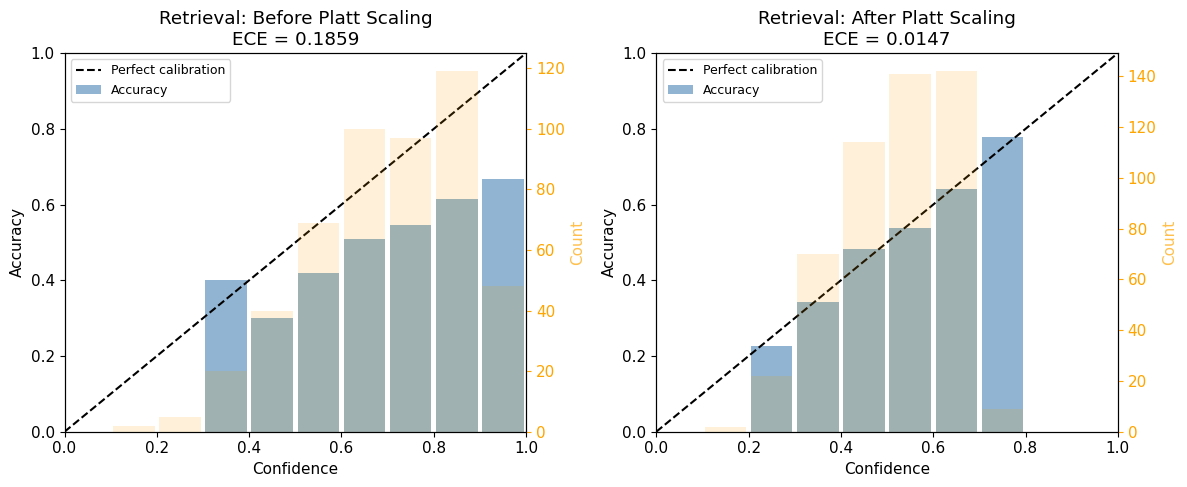

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_reliability(ret_relevant, ret_confs, 'Retrieval: Before Platt Scaling', axes[0])
plot_reliability(ret_relevant, ret_calibrated, 'Retrieval: After Platt Scaling', axes[1])
plt.tight_layout()
plt.show()

## 5. Full RAGCalibrator — Combined Report

In [10]:
cal = RAGCalibrator(n_bins=10)

# calibrate retrieval
ret_report = cal.calibrate_retrieval(ret_confs, ret_relevant)

# calibrate generation
gen_report = cal.calibrate_generation(logits, labels)

report = cal.get_calibration_report()

print('=== Calibration Report ===')
print(f'\nRetrieval:')
print(f'  ECE before: {report["retrieval"]["before"]["ece"]:.4f}')
print(f'  ECE after:  {report["retrieval"]["after"]["ece"]:.4f}')
print(f'  Brier before: {report["retrieval"]["before"]["brier"]:.4f}')
print(f'  Brier after:  {report["retrieval"]["after"]["brier"]:.4f}')
print(f'  Scaler: {report["retrieval"]["scaler"]}')

print(f'\nGeneration:')
print(f'  ECE before: {report["generation"]["before"]["ece"]:.4f}')
print(f'  ECE after:  {report["generation"]["after"]["ece"]:.4f}')
print(f'  Temperature: {report["generation"]["temperature"]:.4f}')
print(f'  Scaler: {report["generation"]["scaler"]}')

=== Calibration Report ===

Retrieval:
  ECE before: 0.1859
  ECE after:  0.0147
  Brier before: 0.2717
  Brier after:  0.2361
  Scaler: PlattScaling(a=2.9737, b=-2.0151)

Generation:
  ECE before: 0.2985
  ECE after:  0.0182
  Temperature: 3.5909
  Scaler: TemperatureScaling(T=3.5909)


## Summary

| Component | Method | What it fixes |
|-----------|--------|---------------|
| Retrieval | Platt scaling | Maps posterior means to calibrated P(relevant) |
| Generation | Temperature scaling | Softens overconfident logits (T > 1) |

**Key takeaway**: Raw model scores are almost always overconfident. Post-hoc calibration is cheap (one scalar parameter) and dramatically improves the trustworthiness of uncertainty estimates.

Next week: integrate everything into a unified pipeline with selective abstention — the system should know when to say "I don't know."